<a href="https://colab.research.google.com/github/heithorqueiroz/arretados-tech/blob/main/pfsr_trabalho4_cap13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dados

In [2]:
# Bibliotecas
import tifffile as tif
import matplotlib.pyplot as plt
import math as m
import numpy as np

ID: LC08_L1TP_027037_20230304_20230316_02_T1
Date Acquired: 2023/03/04
Path: 027
Row: 037

### Clip

In [22]:
# Instalar biblioteca para leitura de shapefile
!pip install fiona
import fiona

# Instalar biblioteca para leitura e manipulação de imagem
!pip install rasterio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

# Read shapefile with fiona
with fiona.open("/content/drive/MyDrive/01_research/05_inpe/01-aulas/P1/principios-fisicos/01-trabalhos/T4-grupo-cap13/shp/dallas/dallas-32614.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Clip imagem TIRS Level 1

In [23]:
# Clipar
src = rasterio.open('/content/drive/MyDrive/01_research/05_inpe/01-aulas/P1/principios-fisicos/01-trabalhos/T4-grupo-cap13/tirs/Level1/LC08_L1TP_027037_20230304_20230316_02_T1_B10.TIF')

# Executando corte
out_img, out_transform = mask(dataset=src, shapes=shapes, crop=True)
out_meta = src.meta.copy()

out_meta.update({
    "driver":"Gtiff",
    "height":out_img.shape[1], # height starts with shape[1]
    "width":out_img.shape[2], # width starts with shape[2]
    "transform":out_transform
})

# Gravando imagem cortada em disco
with rasterio.open('clip-level1.tif', "w", **out_meta) as dest:
  dest.write(out_img)

print(out_meta)

{'driver': 'Gtiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 4156, 'height': 3403, 'count': 1, 'crs': CRS.from_epsg(32614), 'transform': Affine(30.0, 0.0, 626385.0,
       0.0, -30.0, 3680295.0)}


Clip imagem TIRS Level 2

In [24]:
# Clipar
src = rasterio.open('/content/drive/MyDrive/01_research/05_inpe/01-aulas/P1/principios-fisicos/01-trabalhos/T4-grupo-cap13/tirs/Level2/LC08_L2SP_027037_20230304_20230316_02_T1_ST_B10.TIF')

# Executando corte
out_img, out_transform = mask(dataset=src, shapes=shapes, crop=True)
out_meta = src.meta.copy()

out_meta.update({
    "driver":"Gtiff",
    "height":out_img.shape[1], # height starts with shape[1]
    "width":out_img.shape[2], # width starts with shape[2]
    "transform":out_transform
})

# Gravando imagem cortada em disco
with rasterio.open('clip-level2.tif', "w", **out_meta) as dest:
  dest.write(out_img)

print(out_meta)

{'driver': 'Gtiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 4156, 'height': 3403, 'count': 1, 'crs': CRS.from_epsg(32614), 'transform': Affine(30.0, 0.0, 626385.0,
       0.0, -30.0, 3680295.0)}


### Temperatura de brilho

Conversão Nível 1 para Temperatura de Brilho

In [40]:
# Abrir imagem Nível 1 completa
#img = tif.imread('/content/drive/MyDrive/01_research/05_inpe/01-aulas/P1/principios-fisicos/01-trabalhos/T4-grupo-cap13/tirs/Level1/LC08_L1TP_027037_20230304_20230316_02_T1_B10.TIF')

# Abrir imagem Nível 1 clipada
img = tif.imread('/content/clip-level1.tif')

In [41]:
# Instruções conversão: https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product
# Instruções pag 55: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf

# Converter de ND para TOA Radiance
Ml = 3.3420*(10**-4)
Al = 0.1
Qcal = img

L = Ml*Qcal+Al

# Converter de TOA Radiance para TOA Brightness Temperature
k1 = 774.8853
k2 = 1321.0789
T = k2/(np.log(k1/L+1))

Reescalonamento Nível 2 

In [42]:
# Instruções https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products

scale_mult = 0.00341802
scale_add = 149

# Abrir imagem Nível 2 completa
#level2 = tif.imread('/content/drive/MyDrive/01_research/05_inpe/01-aulas/P1/principios-fisicos/01-trabalhos/T4-grupo-cap13/tirs/Level2/LC08_L2SP_027037_20230304_20230316_02_T1_ST_B10.TIF')
# Abrir imagem Nível 2 clipada
level2 = tif.imread('/content/clip-level2.tif')

level2 = level2 * scale_mult + scale_add 

In [54]:
# Setar valores extremos (nesse caso 0) para NaN
import numpy as np
T[T <= 250] = np.NaN

import numpy as np
level2[level2 <= 250] = np.NaN

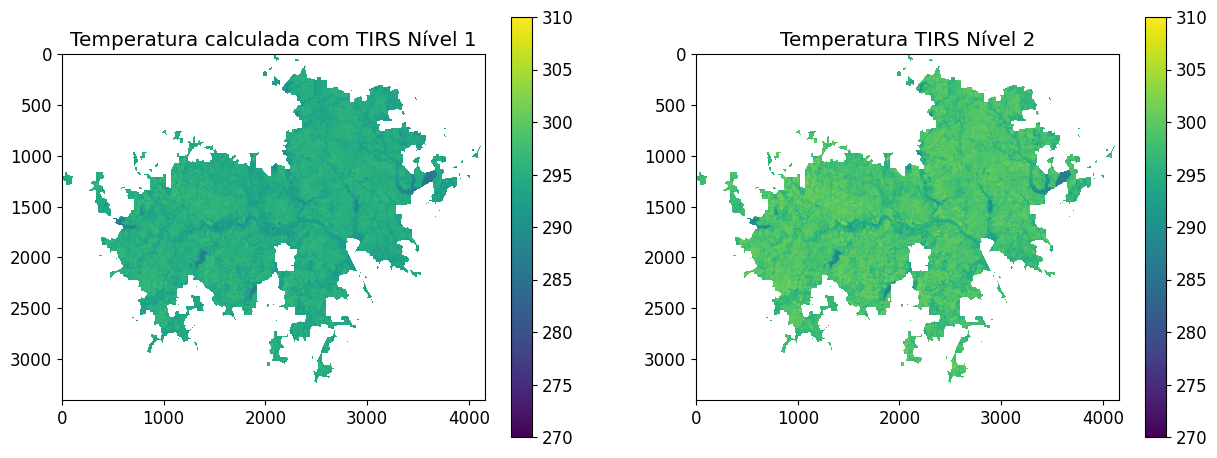

In [72]:
# Plot

# Plot
plt.figure(figsize=(15,12))
plt.rcParams['font.size'] = '12'

subplot(221); plt.imshow(T); title('Temperatura calculada com TIRS Nível 1');
plt.colorbar() 
plt.clim(270,310)
subplot(222); plt.imshow(level2); title('Temperatura TIRS Nível 2')
plt.colorbar()
plt.clim(270,310)


show()

### Histogramas

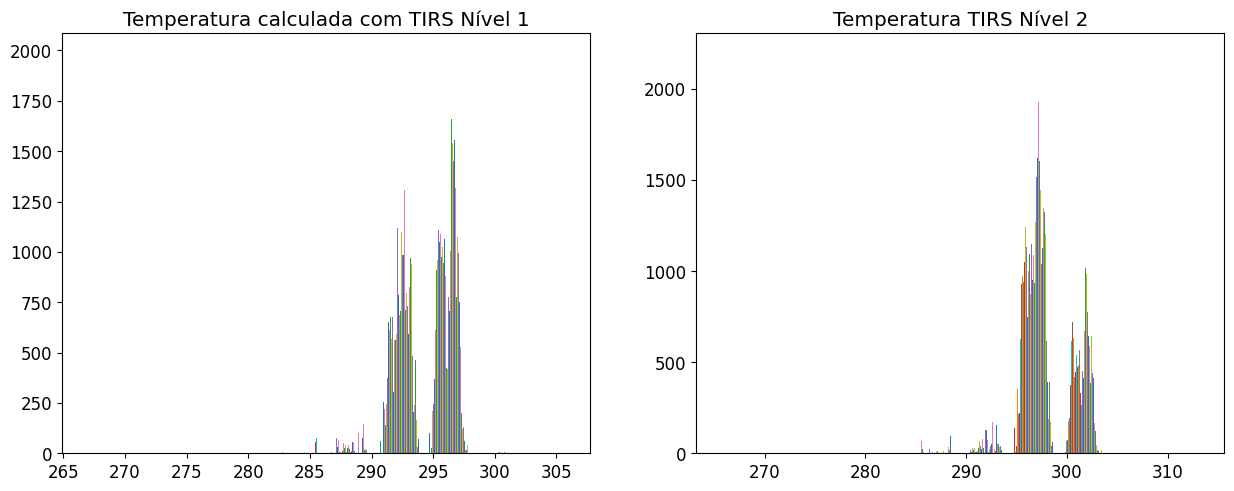

In [75]:
# Plot
plt.figure(figsize=(15,12))
plt.rcParams['font.size'] = '12'

from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist

img1 = T
img2 = level2
subplot(221); hist(img1); title('Temperatura calculada com TIRS Nível 1')
subplot(222); hist(img2); title('Temperatura TIRS Nível 2')

show()

### Testando calculo de diferença

In [7]:
dif = level2 - T

In [15]:
np.max(dif)

24.42203319826001

In [13]:
np.min(T)

147.51709574377605

In [ ]:
!pip install spectral
from spectral import imshow

Text(0.5, 1.0, 'Diferença absoluta: Nível 2 - Calculada')

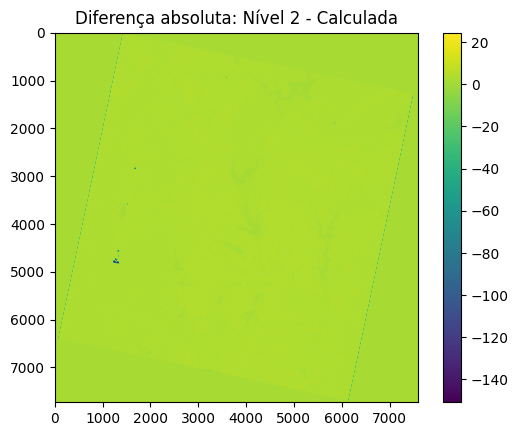

In [12]:
plt.imshow(dif)
plt.colorbar()
plt.title('Diferença absoluta: Nível 2 - Calculada')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, 'Diferença normalizada: Nível 2 - Calculada')

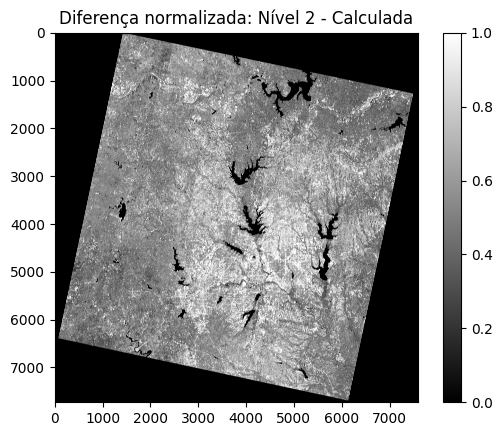

In [12]:
!pip install spectral
from spectral import imshow
imshow(dif, stretch=(0.02,0.98))
plt.colorbar()
plt.title('Diferença normalizada: Nível 2 - Calculada')

In [ ]:
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist


img = T

subplot(221); imshow(img, cmap=get_cmap('gray')); title('Temperatura de Brilho Calculada')
subplot(222); hist(img); title('Histograma')

show()

In [ ]:
img = level2

subplot(221); imshow(img, cmap=get_cmap('gray'));  title('Imagem TIRS nível 2')
subplot(222); hist(img); title('Histograma nível 2')

show()